In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications  import InceptionResNetV2
from sklearn.metrics import confusion_matrix ,plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

epoch_iter = 6

## Step 1
This is the portions where I import the pre_model. I grab layers one in order to visualize it in the next step. The entire summary is printed here, it's very long. Before I turn off the trainable parameters, this model has 54,276,192 trainable parameters. 

In [2]:
pre_model = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(150,150,3))
pre_model.summary()
layer1 = pre_model.get_layer(name=pre_model.layers[1].name)

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

Here I visualize the first layer. I originally made a mistake and tried to visualize the input layer, however, I was unable to do that. The function "deprocess_image" I took directly from the Keras manual site. It was a good way to clean the image up. As per advice from Dr. Rhodes, I just printed the weights of the layer, and used that as my visualization. It had 32 $3 \times 3$ filters, which I displayed below.

It's really interesting because we can see that these little filters are focused on colors and vertical/horizontal lines. They're very primitive compared to the filters that will probably come up later in the model.

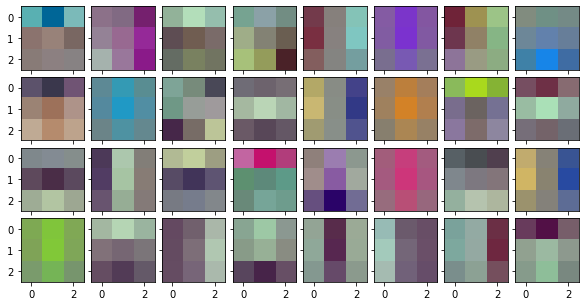

In [3]:
#https://keras.io/examples/vision/visualizing_what_convnets_learn/

w = np.array(layer1.get_weights())
w = w[0].T
w.shape

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15


    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

fig = plt.figure(figsize=(10, 8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),
                 axes_pad=0.1, 
                 )

for ax, im in zip(grid, w):
    # Iterating over the grid returns the Axes.
    ax.imshow(deprocess_image(im))

plt.show()

## Step 2
I imported the images using tensorflow directly. The $ImageDataGenerator$ was a good tool to use for this job. Using it, I could normalize my images and I also split the training data into a validation set(80/20 split). I used this same technique to normalize my test data. Using this data generator, I applied it to my data set with $flow\_from\_directory$ and made 32 batches and resized my imges to RGB $150 \times 150$ images.

For my test data, I did something a little different though. I did not batch the data and I also separated my images and labels in order to use the tensorflow predict function. I found it easier to use that to make my confusion graph later on.

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'dataset/training_set',
        target_size=(150, 150),
        batch_size=32,
        subset= 'training',
        class_mode='binary')
validation_generator = train_datagen.flow_from_directory(
        'dataset/training_set',
        target_size=(150, 150),
        batch_size=32,
        subset= 'validation',
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        'dataset/test_set',
        target_size=(150, 150),
        batch_size=-1,          #no batch size, all in
        class_mode='binary')

images, labels = test_generator.next()
print(images.shape,labels.shape)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
(1999, 150, 150, 3) (1999,)


## Step 3
#### (i)
This is the point where we transfer the old model into the new model. The summary is below and the number of trainable paramters is 57,815,649. And we freeze the pre_model weights and compile model with an adam optimizer, binary crossentropy loss function and set the metric to be based on accuracy.

In [5]:
model = models.Sequential()
model.add(pre_model)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________
None


In [6]:
pre_model.trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

## Step 4
#### (i)
This is when I used predict using the model with the set of test images. The confusion matrix below and the accuracy shows that the model is pretty much guessing. This is obvious because it's accuracy at about ~ 50%.

63/63 [==============================] - 26s 371ms/step - loss: 1.3656 - accuracy: 0.5416
test loss, test acc: [1.3934545516967773, 0.5412706136703491]
[[981  19]
 [898 101]]


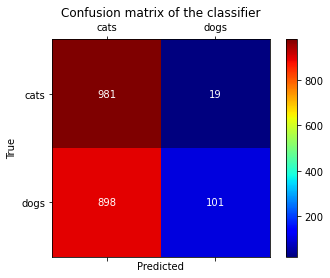

In [7]:
results = model.evaluate(images,labels)
print("test loss, test acc:", results)

predictions = model.predict(images)
lab = ['cats', 'dogs']
cm = confusion_matrix(labels, tf.math.round(predictions))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap = "jet")
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(lab)))
ax.set_yticks(np.arange(len(lab)))
ax.set_xticklabels(lab)
ax.set_yticklabels(lab)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.show()

#### (ii)
This is when we train the model. I used the validation data to get a better sense of how the model is doing after each epoch. I'm going to keep the epochs relatively small, and make have 100 iteration per epoch and 6 epochs. 

Below we can see that TensorFlow displays the loss and the accuracy of borth the training data and the validation. The loss drops quickly and the accuracy rises quickly during the first epoch. After that, the accruracy continues to improve, but not very quickly. The validation is also not as good as the training data, but that is to be expected.

In [8]:
model.fit(
        train_generator,
        epochs=epoch_iter,
        batch_size=32,
        steps_per_epoch=100,
        validation_freq=1,
        validation_data=validation_generator,
        verbose = 1)

Epoch 1/6
100/100 [==============================] - 67s 617ms/step - loss: 0.4933 - accuracy: 0.8050 - val_loss: 0.3045 - val_accuracy: 0.8769
Epoch 2/6
100/100 [==============================] - 59s 591ms/step - loss: 0.3032 - accuracy: 0.8741 - val_loss: 1.0448 - val_accuracy: 0.8112
Epoch 3/6
100/100 [==============================] - 59s 593ms/step - loss: 0.2769 - accuracy: 0.8803 - val_loss: 1.0148 - val_accuracy: 0.7856
Epoch 4/6
100/100 [==============================] - 59s 590ms/step - loss: 0.2185 - accuracy: 0.9053 - val_loss: 1.6842 - val_accuracy: 0.8369
Epoch 5/6
100/100 [==============================] - 59s 591ms/step - loss: 0.1972 - accuracy: 0.9187 - val_loss: 0.8589 - val_accuracy: 0.9006
Epoch 6/6
100/100 [==============================] - 59s 589ms/step - loss: 0.2128 - accuracy: 0.9103 - val_loss: 7.2829 - val_accuracy: 0.8800


This is when we do the evaluation on the test set. The confusion matrix below is displayed, and it shows that the model does much better (~90%).

In [9]:
results = model.evaluate(images,labels)
print("test loss, test acc:", results)

63/63 [==============================] - 23s 368ms/step - loss: 6.3730 - accuracy: 0.8914
test loss, test acc: [6.372960090637207, 0.8914456963539124]


[[919  81]
 [136 863]]


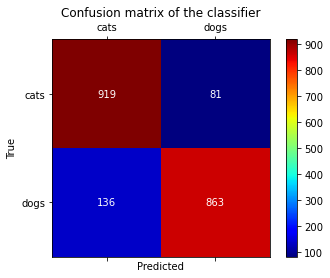

In [10]:
predictions = model.predict(images)
lab = ['cats', 'dogs']
cm = confusion_matrix(labels, tf.math.round(predictions))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap = "jet")
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(lab)))
ax.set_yticks(np.arange(len(lab)))
ax.set_xticklabels(lab)
ax.set_yticklabels(lab)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.show()

#### (iii)
This is when I create my sub network. The network is almost exactly the same as the last one, except the pre_model stops at layer 27 and trains for 30 epochs. Scaling the model down did not imprve the performance at all. In fact it went way down. I tried to raise the accuracy with more training, however that didn't help as much. The model stops at around ~70% with the training data, and ~60% with the test data. That means that the model is doing slightly better than a guess. 

I will say that the model trains a lot faster though.

In [11]:
subnetLayer = 27

subnet = pre_model.layers[subnetLayer].output
my_subnet = keras.layers.Dense(units=128, activation="relu")(subnet)
my_submodel = keras.models.Model(inputs=pre_model.input, outputs=my_subnet)
my_submodel.trainable = False
print(len(my_submodel.layers))
print(my_submodel.summary())

20
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 74, 74, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        96        
_________________________________________________________________
activation (Activation)      (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0  

In [12]:
new_model = models.Sequential()
new_model.add(my_submodel.layers[0])
new_model.add(layers.Flatten())
new_model.add(layers.Dense(256,activation='relu'))
new_model.add(layers.Dense(1,activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 3,539,457
Non-trainable params: 54,336,736
_________________________________________________________________
None


In [13]:
my_submodel.trainable = False

new_model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

[[483 517]
 [529 470]]


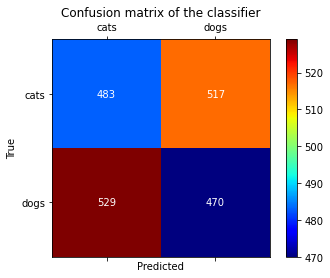

In [14]:
predictions = new_model.predict(images)
lab = ['cats', 'dogs']
cm = confusion_matrix(labels, tf.math.round(predictions))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap = "jet")
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(lab)))
ax.set_yticks(np.arange(len(lab)))
ax.set_xticklabels(lab)
ax.set_yticklabels(lab)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.show()

In [15]:
new_model.fit(
        train_generator,
        epochs=30,
        batch_size=32,
        steps_per_epoch=200,
        validation_freq=5,
        validation_data=validation_generator,
        verbose = 1)

Epoch 1/30
200/200 [==============================] - 11s 52ms/step - loss: 11.8383 - accuracy: 0.5034
Epoch 2/30
200/200 [==============================] - 9s 47ms/step - loss: 3.2282 - accuracy: 0.5329
Epoch 3/30
200/200 [==============================] - 9s 47ms/step - loss: 1.5266 - accuracy: 0.5780
Epoch 4/30
200/200 [==============================] - 9s 43ms/step - loss: 1.5425 - accuracy: 0.5861
Epoch 5/30
200/200 [==============================] - 11s 54ms/step - loss: 1.4238 - accuracy: 0.5991 - val_loss: 1.0738 - val_accuracy: 0.5569
Epoch 6/30
200/200 [==============================] - 9s 43ms/step - loss: 1.1675 - accuracy: 0.5899
Epoch 7/30
200/200 [==============================] - 9s 43ms/step - loss: 0.8598 - accuracy: 0.5987
Epoch 8/30
200/200 [==============================] - 9s 43ms/step - loss: 0.6459 - accuracy: 0.6561
Epoch 9/30
200/200 [==============================] - 9s 43ms/step - loss: 0.7584 - accuracy: 0.6334
Epoch 10/30
200/200 [=========================

In [16]:
results = new_model.evaluate(images,labels)
print("test loss, test acc:", results)

63/63 [==============================] - 1s 15ms/step - loss: 0.6550 - accuracy: 0.6238
test loss, test acc: [0.6549517512321472, 0.6238119006156921]


[[659 341]
 [411 588]]


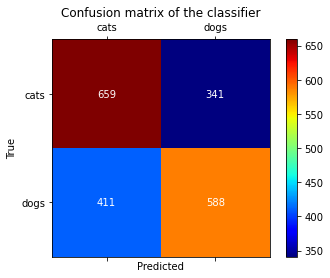

In [17]:
predictions = new_model.predict(images)
lab = ['cats', 'dogs']
cm = confusion_matrix(labels, tf.math.round(predictions))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap = "jet")
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(lab)))
ax.set_yticks(np.arange(len(lab)))
ax.set_xticklabels(lab)
ax.set_yticklabels(lab)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.show()